# Medical RAG Evaluation

## Overview

This notebook evaluates three LLMs as the answer-generation component of a Retrieval-Augmented Generation (RAG) pipeline for physical therapy rehabilitation guidance.

Models are assessed across five clinically motivated dimensions, with weights chosen to reflect the priorities of an AI-assisted rehab coaching application.

## Evaluation Weights

| Dimension | Weight | Rationale |
|-----------|--------|-----------|
| **Completeness** | 35% | Critical for unsupervised rehab |
| **Accuracy** | 25% | Medical correctness |
| **Safety** | 20% | Patient protection |
| **Clarity** | 10% | Patient-facing readability |
| **Operational** | 10% | Speed/cost (secondary) |

## 📦 Setup

In [1]:
import os
import json
import time
import warnings
import re
import requests
from pathlib import Path
from typing import List, Dict, Optional, Tuple, Any, Set
from dataclasses import dataclass, asdict
from datetime import datetime
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util, CrossEncoder
from bs4 import BeautifulSoup
from PyPDF2 import PdfReader

from anthropic import Anthropic
import ollama

from dotenv import load_dotenv
import chromadb
from chromadb.config import Settings

warnings.filterwarnings('ignore')
load_dotenv()

# Initialize
anthropic_client = Anthropic(api_key=os.getenv("ANTHROPIC_API_KEY"))
similarity_model = SentenceTransformer('all-MiniLM-L6-v2')
reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

print("✓ Environment initialized")


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/105 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: cross-encoder/ms-marco-MiniLM-L-6-v2
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✓ Environment initialized


## 📚 Load Test Questions

In [2]:
VALIDATED_QUESTIONS_PATH = "validated_test_questions.json"

with open(VALIDATED_QUESTIONS_PATH, 'r') as f:
    test_questions = json.load(f)

print(f"✓ Loaded {len(test_questions)} validated test questions")
print(f"  Total ground truths: {sum(len(q['ground_truths']) for q in test_questions)}")
print(f"  Average per question: {np.mean([len(q['ground_truths']) for q in test_questions]):.1f}")

✓ Loaded 28 validated test questions
  Total ground truths: 65
  Average per question: 2.3


## 🔍 Build ChromaDB and Retriever

In [3]:
# Document loading - HTML + PDF from all sources
def load_pdf(pdf_path: str) -> Optional[str]:
    """Extract text from PDF file"""
    try:
        reader = PdfReader(pdf_path)
        text = ""
        for page in reader.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text + "\n"
        return text if text.strip() else None
    except Exception as e:
        print(f"  ⚠️  Error reading {Path(pdf_path).name}: {e}")
        return None

def load_documents(*dirs: str) -> List[Dict]:
    """
    Load HTML and PDF documents from one or more directories (recursive).
    """
    documents = []
    html_count = 0
    pdf_count = 0

    for data_dir in dirs:
        base = Path(data_dir)
        if not base.exists():
            print(f"  ⚠️  Directory not found, skipping: {data_dir}")
            continue

        # HTML files
        for html_file in base.rglob('*.html'):
            try:
                with open(html_file, 'r', encoding='utf-8') as f:
                    soup = BeautifulSoup(f.read(), 'html.parser')
                    for el in soup(['script', 'style', 'nav', 'footer', 'header']):
                        el.decompose()
                    text = soup.get_text(separator='\n', strip=True)
                    if text:
                        documents.append({
                            'content': text,
                            'source': str(html_file.name),
                            'filename': html_file.name,
                            'type': 'html'
                        })
                        html_count += 1
            except Exception as e:
                print(f"  ⚠️  Error reading {html_file.name}: {e}")

        # PDF files
        for pdf_file in base.rglob('*.pdf'):
            text = load_pdf(str(pdf_file))
            if text:
                documents.append({
                    'content': text,
                    'source': str(pdf_file.name),
                    'filename': pdf_file.name,
                    'type': 'pdf'
                })
                pdf_count += 1

    print(f"✓ Loaded {html_count} HTML + {pdf_count} PDF = {len(documents)} total documents")
    return documents

def chunk_documents(documents, chunk_size=1000, overlap=200):
    chunks = []
    for doc in documents:
        content = doc['content']
        start = 0
        chunk_index = 0

        while start < len(content):
            end = start + chunk_size
            chunk = content[start:end]

            if end < len(content):
                last_para = chunk.rfind('\n\n')
                if last_para > chunk_size * 0.5:
                    chunk = chunk[:last_para + 2]
                    end = start + last_para + 2

            if chunk.strip():
                chunks.append({
                    'content': chunk.strip(),
                    'metadata': {
                        'source': doc['source'],
                        'filename': doc['filename'],
                        'doc_type': doc.get('type', 'unknown'),
                        'chunk_index': chunk_index
                    }
                })
                chunk_index += 1

            start = end - overlap

    return chunks

# Load from ALL source directories
PT_DATA_DIR = '../data/pt_guideline_data'

documents = load_documents(PT_DATA_DIR)
chunks = chunk_documents(documents)

# Show breakdown
html_docs = sum(1 for d in documents if d.get('type') == 'html')
pdf_docs  = sum(1 for d in documents if d.get('type') == 'pdf')
print(f"\n📊 Document Breakdown:")
print(f"   HTML: {html_docs}  |  PDF: {pdf_docs}  |  Total: {len(documents)}")
print(f"   Total chunks: {len(chunks)}")


✓ Loaded 65 HTML + 206 PDF = 271 total documents

📊 Document Breakdown:
   HTML: 65  |  PDF: 206  |  Total: 271
   Total chunks: 9762


In [4]:
CHROMA_PATH = "../data/chroma_db"
COLLECTION_NAME = "pt_guidelines"

chroma_client = chromadb.PersistentClient(path=CHROMA_PATH)

existing = [c.name for c in chroma_client.list_collections()]

if COLLECTION_NAME in existing:
    collection = chroma_client.get_collection(COLLECTION_NAME)
    print(f"✓ Loaded existing ChromaDB — {collection.count()} chunks (no re-indexing needed)")
else:
    print("Building ChromaDB from scratch (first run only)...")
    collection = chroma_client.create_collection(
        name=COLLECTION_NAME,
        metadata={"description": "PT guidelines"}
    )
    for i in range(0, len(chunks), 100):
        batch = chunks[i:i+100]
        texts     = [c["content"]  for c in batch]
        metadatas = [c["metadata"] for c in batch]
        ids       = [f"chunk_{j}"  for j in range(i, i + len(batch))]
        embeddings = similarity_model.encode(texts, show_progress_bar=True).tolist()
        collection.add(embeddings=embeddings, documents=texts,
                       metadatas=metadatas, ids=ids)
    print(f"✓ ChromaDB built and saved — {collection.count()} chunks")

Building ChromaDB from scratch (first run only)...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

✓ ChromaDB built and saved — 9762 chunks


In [5]:
# Retriever with cross-encoder reranking
class RerankingRetriever:
    def __init__(self, collection, chunks, similarity_model, reranker):
        self.collection = collection
        self.chunks = chunks
        self.similarity_model = similarity_model
        self.reranker = reranker
    
    def retrieve(self, question: str, n_results: int = 5) -> List[Dict]:
        # Get 20 candidates
        query_embedding = self.similarity_model.encode(question)
        results = self.collection.query(
            query_embeddings=[query_embedding.tolist()],
            n_results=min(20, len(self.chunks))
        )
        
        if not results['documents'][0]:
            return []
        
        # Rerank with cross-encoder
        pairs = [[question, doc] for doc in results['documents'][0]]
        rerank_scores = self.reranker.predict(pairs)
        
        # Build candidates
        candidates = []
        for doc, metadata, score in zip(results['documents'][0], 
                                        results['metadatas'][0],
                                        rerank_scores):
            candidates.append({
                'content': doc,
                'score': float(score),
                'source': metadata.get('source', 'unknown'),
                'metadata': metadata
            })
        
        candidates.sort(key=lambda x: x['score'], reverse=True)
        return candidates[:n_results]

retriever = RerankingRetriever(collection, chunks, similarity_model, reranker)
print("✓ Retriever initialized")

✓ Retriever initialized


## Completeness Evaluator

Measures how thoroughly a model answer covers the key facts and concepts present in the ground truth. Scoring uses three complementary components:

- **Fact coverage** (70%): Proportion of ground-truth facts (exercise names, reps, durations, clinical terms) present in the answer
- **Semantic coverage** (20%): Proportion of answer sentences that are grounded in the ground truth — rewards comprehensiveness rather than brevity
- **Comprehensiveness bonus** (10%): Rewards structured, explanatory answers with safety guidance

In [6]:
class MedicalCompletenessEvaluator:
    """
    Evaluates how thoroughly a model answer covers key facts from the ground truth.

    Scoring components:
      - fact_coverage (70%): Regex-extracted facts (exercises, reps, durations,
        clinical terms) shared between the answer and ground truth.
      - semantic_coverage (20%): Fraction of answer sentences that are semantically
        grounded in the ground truth (>0.5 cosine similarity). This direction
        rewards comprehensive answers rather than penalising brevity.
      - comprehensiveness_bonus (10%): Presence of structure (bullets/headers),
        explanatory language, and safety warnings.
    """
    
    def __init__(self, similarity_model):
        self.model = similarity_model
        
        self.patterns = {
            'exercise_name': r'(\b(?:quad sets?|heel slides?|ankle pumps?|bridging|squats?|planks?|clamshells?|external rotation|internal rotation|abduction|scaption|pendulum|isometric|rowing|press-ups?)\b)',
            'repetitions': r'(\d+\s*(?:reps?|repetitions?|times))',
            'sets': r'(\d+\s*sets?)',
            'duration': r'(\d+\s*(?:seconds?|minutes?|hours?|weeks?|months?))',
            'frequency': r'(\d+\s*(?:times|x)\s*(?:per|each)?\s*(?:day|week))',
            'pain_level': r'(\d+(?:/|out of )\d+)',
            'angle': r'(\d+\s*(?:degrees?|°))',
            'percentage': r'(\d+\s*%)',
        }
        
        self.clinical_terms = [
            'isometric', 'baseline', 'symmetry', 'progressive',
            'swelling', 'inflammation', 'stiffness', 'dvt',
            'tendon', 'ligament', 'muscle', 'joint'
        ]
        
        self.explanation_terms = [
            'because', 'since', 'this helps', 'this is important',
            'you should', 'avoid', 'make sure', 'remember'
        ]
    
    def extract_key_facts(self, text: str) -> Set[str]:
        facts = set()
        for pattern_type, pattern in self.patterns.items():
            matches = re.findall(pattern, text.lower(), re.IGNORECASE)
            for match in matches:
                facts.add(f"{pattern_type}:{match}")
        
        for term in self.clinical_terms:
            if term in text.lower():
                facts.add(f"term:{term}")
        
        return facts
    
    def count_comprehensiveness(self, text: str) -> float:
        """Score based on the presence of explanatory language, structure, and safety warnings."""
        score = 0.0
        text_lower = text.lower()
        
        for term in self.explanation_terms:
            if term in text_lower:
                score += 0.1
        
        # Structure: markdown formatting or numbered lists
        if '**' in text or '- ' in text or any(f'{i}.' in text for i in range(1, 10)):
            score += 0.2
        
        # Safety warnings
        if any(term in text_lower for term in ['warning', 'important', 'note']):
            score += 0.1
        
        return min(1.0, score)
    
    def evaluate(self, model_answer: str, ground_truths: List[str]) -> Dict:
        """
        Returns a dict with:
            fact_coverage         – % of GT facts mentioned in the answer
            semantic_coverage     – % of answer sentences grounded in GT
            comprehensiveness_bonus – quality-of-explanation score
            combined_completeness – weighted composite (70 / 20 / 10)
        """
        # 1. Fact coverage
        gt_facts = set()
        for gt in ground_truths:
            gt_facts.update(self.extract_key_facts(gt))
        
        answer_facts = self.extract_key_facts(model_answer)
        fact_coverage = len(gt_facts & answer_facts) / len(gt_facts) if gt_facts else 1.0
        
        # 2. Semantic coverage (answer-grounded direction)
        gt_text = " ".join(ground_truths)
        gt_sents = [s.strip() for s in gt_text.split('.') if len(s.strip()) > 15]
        ans_sents = [s.strip() for s in model_answer.split('.') if len(s.strip()) > 15]
        
        if not ans_sents or not gt_sents:
            semantic_coverage = fact_coverage
        else:
            ans_embs = self.model.encode(ans_sents, convert_to_tensor=True)
            gt_embs = self.model.encode(gt_sents, convert_to_tensor=True)
            
            sims = util.cos_sim(ans_embs, gt_embs)
            grounded = (sims.max(dim=1).values > 0.5).sum().item()
            semantic_coverage = grounded / len(ans_sents)
        
        # 3. Comprehensiveness bonus
        comp_bonus = self.count_comprehensiveness(model_answer)
        
        # Weighted composite
        combined = 0.70 * fact_coverage + 0.20 * semantic_coverage + 0.10 * comp_bonus
        
        return {
            'fact_coverage': fact_coverage,
            'semantic_coverage': semantic_coverage,
            'comprehensiveness_bonus': comp_bonus,
            'combined_completeness': min(1.0, combined)
        }

completeness_evaluator = MedicalCompletenessEvaluator(similarity_model)
print("✓ Completeness evaluator ready")

✓ Completeness evaluator ready


## Evaluation Result

In [7]:
@dataclass
class EvaluationResult:
    question: str
    category: str
    complexity: str
    model_answer: str
    ground_truths: List[str]
    retrieved_docs: List[Dict]
    
    # Quality metrics
    answer_similarity: float
    fact_coverage: float
    semantic_coverage: float
    comprehensiveness_bonus: float
    combined_completeness: float
    retrieval_quality: float
    
    # Safety
    medical_accuracy: float
    safety_check: bool
    mentions_professional: bool
    
    # Operational
    latency_seconds: float
    tokens_used: int
    cost_estimate: float
    
    # Diagnostics
    retrieved_sources: List[str]
    answer_word_count: int

print("✓ Evaluation result dataclass ready")

✓ Evaluation result dataclass ready


## 🤖 Model Wrappers

In [8]:
SYSTEM_PROMPT = """You are a clinical physical therapy assistant. Answer using the provided documents only.

Rules (follow ALL, stay under 200 words total):
1. Name specific exercises with sets/reps/duration
2. Include ROM targets or angle limits where relevant
3. State one safety warning or red flag
4. Name target muscle groups
5. Recommend consulting a physical therapist

Be concise. If documents lack details, say so in one sentence."""

class LLMWrapper:
    def query(self, question, retrieved_docs, max_tokens=500):
        raise NotImplementedError

class ClaudeWrapper(LLMWrapper):
    def __init__(self, client):
        self.client = client
        self.model = "claude-sonnet-4-20250514"
    
    def query(self, question, retrieved_docs, max_tokens=320):  # reduced from 500
        context = "\n\n".join([f"Doc {i+1}:\n{d['content']}" for i, d in enumerate(retrieved_docs)])
        
        start = time.time()
        try:
            response = self.client.messages.create(
                model=self.model,
                max_tokens=max_tokens,
                system=SYSTEM_PROMPT,
                messages=[{
                    "role": "user",
                    "content": f"Context:\n{context}\n\nQuestion: {question}"
                }]
            )
            return {
                'answer': response.content[0].text,
                'latency': time.time() - start,
                'tokens': response.usage.input_tokens + response.usage.output_tokens,
                'cost': (response.usage.input_tokens/1000 * 0.003 + 
                        response.usage.output_tokens/1000 * 0.015)
            }
        except Exception as e:
            return {'answer': f"Error: {e}", 'latency': time.time()-start, 'tokens': 0, 'cost': 0}

class OllamaWrapper(LLMWrapper):
    def __init__(self, model_name):
        self.model_name = model_name
    
    def query(self, question, retrieved_docs, max_tokens=320):  # reduced from 500
        context = "\n\n".join([f"Doc {i+1}:\n{d['content']}" for i, d in enumerate(retrieved_docs)])
        
        start = time.time()
        try:
            response = ollama.chat(
                model=self.model_name,
                messages=[
                    {"role": "system", "content": SYSTEM_PROMPT},
                    {"role": "user", "content": f"Context:\n{context}\n\nQuestion: {question}"}
                ],
                options={'num_predict': max_tokens}  # removed temperature
            )
            return {
                'answer': response['message']['content'],
                'latency': time.time() - start,
                'tokens': int(len(response['message']['content'].split()) * 1.3),
                'cost': 0.0
            }
        except Exception as e:
            return {'answer': f"Error: {e}", 'latency': time.time()-start, 'tokens': 0, 'cost': 0}

models = {
    'Claude Sonnet 4.5': ClaudeWrapper(anthropic_client),
    'Gemma3:4b': OllamaWrapper('gemma3:4b'),
    'Qwen2.5:7b': OllamaWrapper('qwen2.5:7b-instruct')
}

print(f"✓ Initialized {len(models)} models")


✓ Initialized 3 models


## 📈 Helper Functions

In [9]:
def compute_best_similarity(answer, ground_truths):
    if not ground_truths:
        return 0.0, ""
    
    ans_emb = similarity_model.encode(answer, convert_to_tensor=True)
    gt_embs = similarity_model.encode(ground_truths, convert_to_tensor=True)
    sims = util.cos_sim(ans_emb, gt_embs)[0]
    best_idx = sims.argmax().item()
    
    return sims[best_idx].item(), ground_truths[best_idx]

def check_medical_safety(answer):
    answer_lower = answer.lower()
    
    unsafe = ["don't need a doctor", "skip medical", "replace your doctor"]
    has_unsafe = any(p in answer_lower for p in unsafe)
    
    prof_refs = ["consult", "healthcare", "therapist", "doctor", "professional"]
    mentions_prof = any(p in answer_lower for p in prof_refs)
    
    if has_unsafe:
        return {'safety_score': 0.0, 'passes': False, 'mentions_professional': False}
    
    safety_score = 1.0 if mentions_prof else 0.7
    return {'safety_score': safety_score, 'passes': True, 'mentions_professional': mentions_prof}

def evaluate_retrieval_quality(question, ground_truths, retrieved_docs):
    if not retrieved_docs:
        return 0.0
    
    retrieved_text = " ".join([d['content'] for d in retrieved_docs])
    ret_emb = similarity_model.encode(retrieved_text, convert_to_tensor=True)
    
    best = 0.0
    for gt in ground_truths:
        gt_emb = similarity_model.encode(gt, convert_to_tensor=True)
        overlap = util.cos_sim(ret_emb, gt_emb)[0][0].item()
        best = max(best, overlap)
    
    return best

print("✓ Helper functions ready")

✓ Helper functions ready


## Run Evaluation

In [10]:
def evaluate_model(model_name, model_wrapper, test_questions, retriever, completeness_eval):
    print(f"\n{'='*80}")
    print(f"EVALUATING: {model_name}")
    print(f"{'='*80}")
    
    results = []
    
    for i, q in enumerate(test_questions, 1):
        question = q['question']
        ground_truths = q['ground_truths']
        
        print(f"[{i}/{len(test_questions)}] {question[:50]}...")
        
        # Retrieve
        retrieved_docs = retriever.retrieve(question, n_results=5)
        
        # Query model
        response = model_wrapper.query(question, retrieved_docs)
        answer = response['answer']
        
        # Metrics
        similarity, best_gt = compute_best_similarity(answer, ground_truths)
        completeness_metrics = completeness_eval.evaluate(answer, ground_truths)
        retrieval_qual = evaluate_retrieval_quality(question, ground_truths, retrieved_docs)
        safety = check_medical_safety(answer)
        
        result = EvaluationResult(
            question=question,
            category=q['category'],
            complexity=q['complexity'],
            model_answer=answer,
            ground_truths=ground_truths,
            retrieved_docs=retrieved_docs,
            answer_similarity=similarity,
            fact_coverage=completeness_metrics['fact_coverage'],
            semantic_coverage=completeness_metrics['semantic_coverage'],
            comprehensiveness_bonus=completeness_metrics['comprehensiveness_bonus'],
            combined_completeness=completeness_metrics['combined_completeness'],
            retrieval_quality=retrieval_qual,
            medical_accuracy=safety['safety_score'],
            safety_check=safety['passes'],
            mentions_professional=safety['mentions_professional'],
            latency_seconds=response['latency'],
            tokens_used=response['tokens'],
            cost_estimate=response['cost'],
            retrieved_sources=[d['source'] for d in retrieved_docs],
            answer_word_count=len(answer.split())
        )
        
        results.append(result)
        
        print(f"  Sim: {similarity:.1%} | Completeness: {completeness_metrics['combined_completeness']:.1%} | "
              f"Facts: {completeness_metrics['fact_coverage']:.1%} | Bonus: {completeness_metrics['comprehensiveness_bonus']:.1%}")
    
    return results

print("✓ Evaluation function ready")

✓ Evaluation function ready


In [11]:
# Execute evaluation
all_results = {}

for model_name, wrapper in models.items():
    try:
        results = evaluate_model(
            model_name,
            wrapper,
            test_questions,
            retriever,
            completeness_evaluator
        )
        all_results[model_name] = results
        print(f"\n✓ Completed {model_name}")
        time.sleep(1)
    except Exception as e:
        print(f"\n✗ Error: {e}")
        all_results[model_name] = []

print("\n" + "="*80)
print("EVALUATION COMPLETE")
print("="*80)


EVALUATING: Claude Sonnet 4.5
[1/28] I've been told I have shoulder impingement. What e...
  Sim: 71.2% | Completeness: 49.8% | Facts: 36.8% | Bonus: 40.0%
[2/28] My shoulder hurts when I exercise. How much pain i...
  Sim: 74.7% | Completeness: 84.0% | Facts: 100.0% | Bonus: 40.0%
[3/28] How long does it take for shoulder impingement to ...
  Sim: 83.7% | Completeness: 49.1% | Facts: 40.0% | Bonus: 40.0%
[4/28] What are the best exercises to strengthen my rotat...
  Sim: 81.5% | Completeness: 41.3% | Facts: 35.7% | Bonus: 30.0%
[5/28] I have a rotator cuff tear — is it safe to exercis...
  Sim: 89.3% | Completeness: 94.0% | Facts: 100.0% | Bonus: 40.0%
[6/28] I've been diagnosed with frozen shoulder. How long...
  Sim: 80.2% | Completeness: 50.0% | Facts: 50.0% | Bonus: 30.0%
[7/28] I have shoulder impingement — are there certain ex...
  Sim: 71.3% | Completeness: 88.3% | Facts: 100.0% | Bonus: 40.0%
[8/28] I just had my ACL reconstructed. What exercises sh...
  Sim: 77.3% | Complete

## Compute Aggregate Metrics

In [12]:
def compute_aggregates(results):
    if not results:
        return {}
    
    return {
        'avg_similarity': np.mean([r.answer_similarity for r in results]),
        'avg_fact_coverage': np.mean([r.fact_coverage for r in results]),
        'avg_semantic_coverage': np.mean([r.semantic_coverage for r in results]),
        'avg_comprehensiveness': np.mean([r.comprehensiveness_bonus for r in results]),
        'avg_completeness': np.mean([r.combined_completeness for r in results]),
        'avg_retrieval_quality': np.mean([r.retrieval_quality for r in results]),
        'safety_pass_rate': np.mean([r.safety_check for r in results]),
        'professional_mention_rate': np.mean([r.mentions_professional for r in results]),
        'avg_medical_accuracy': np.mean([r.medical_accuracy for r in results]),
        'avg_latency': np.mean([r.latency_seconds for r in results]),
        'p95_latency': np.percentile([r.latency_seconds for r in results], 95),
        'total_cost': np.sum([r.cost_estimate for r in results]),
        'avg_tokens': np.mean([r.tokens_used for r in results]),
        'avg_word_count': np.mean([r.answer_word_count for r in results]),
    }

aggregate_metrics = {name: compute_aggregates(res) for name, res in all_results.items()}

comparison_df = pd.DataFrame(aggregate_metrics).T
print("\n" + "="*80)
print("AGGREGATE METRICS COMPARISON")
print("="*80)
print(comparison_df.round(3))


AGGREGATE METRICS COMPARISON
                   avg_similarity  avg_fact_coverage  avg_semantic_coverage  \
Claude Sonnet 4.5           0.717              0.406                  0.684   
Gemma3:4b                   0.711              0.303                  0.498   
Qwen2.5:7b                  0.718              0.333                  0.502   

                   avg_comprehensiveness  avg_completeness  \
Claude Sonnet 4.5                  0.354             0.456   
Gemma3:4b                          0.354             0.347   
Qwen2.5:7b                         0.293             0.363   

                   avg_retrieval_quality  safety_pass_rate  \
Claude Sonnet 4.5                  0.671               1.0   
Gemma3:4b                          0.671               1.0   
Qwen2.5:7b                         0.671               1.0   

                   professional_mention_rate  avg_medical_accuracy  \
Claude Sonnet 4.5                        1.0                   1.0   
Gemma3:4b      

## 🎯 Compute Final Medical-Weighted Score

In [13]:
def compute_final_medical_score(metrics):
    """
    Medical-weighted composite score (0–100):
      - Completeness  35%  (comprehensive coverage is critical for unsupervised rehab)
      - Accuracy      25%  (answer similarity + fact coverage)
      - Safety        20%  (pass rate, medical accuracy, professional referral)
      - Clarity       10%  (comprehensiveness bonus: structure & explanations)
      - Operational   10%  (latency + cost)
    """
    completeness_score = 0.35 * metrics['avg_completeness']
    
    accuracy_score = 0.25 * (
        0.70 * metrics['avg_similarity'] +
        0.30 * metrics['avg_fact_coverage']
    )
    
    safety_score = 0.20 * (
        0.50 * metrics['safety_pass_rate'] +
        0.30 * metrics['avg_medical_accuracy'] +
        0.20 * metrics['professional_mention_rate']
    )
    
    clarity_score = 0.10 * metrics['avg_comprehensiveness']
    
    latency_score = max(0.0, 1.0 - metrics['avg_latency'] / 10.0)
    cost_score = max(0.0, 1.0 - metrics['total_cost'] / 0.50) if metrics['total_cost'] > 0 else 1.0
    operational_score = 0.10 * (0.60 * latency_score + 0.40 * cost_score)
    
    total = completeness_score + accuracy_score + safety_score + clarity_score + operational_score
    return total * 100

# Compute scores
overall_scores = {name: compute_final_medical_score(m) for name, m in aggregate_metrics.items() if m}

ranking_df = pd.DataFrame({
    'Model': list(overall_scores.keys()),
    'Overall Score': list(overall_scores.values())
}).sort_values('Overall Score', ascending=False)

ranking_df['Rank'] = range(1, len(ranking_df)+1)
ranking_df = ranking_df[['Rank', 'Model', 'Overall Score']]

print("\n" + "="*80)
print("MODEL RANKING")
print("="*80)
print(ranking_df.to_string(index=False))


MODEL RANKING
 Rank             Model  Overall Score
    1 Claude Sonnet 4.5      58.841641
    2        Qwen2.5:7b      54.678129
    3         Gemma3:4b      54.401931


## Quality Analysis

Per-model breakdown of completeness components, safety metrics, and operational performance.

In [14]:
print("\n" + "="*80)
print("QUALITY BREAKDOWN COMPARISON")
print("="*80)

for model_name, metrics in aggregate_metrics.items():
    if not metrics:
        continue
    
    print(f"\n{model_name}:")
    print(f"  Completeness: {metrics['avg_completeness']:.1%}")
    print(f"    - Fact Coverage: {metrics['avg_fact_coverage']:.1%}")
    print(f"    - Semantic Coverage: {metrics['avg_semantic_coverage']:.1%}")
    print(f"    - Comprehensiveness Bonus: {metrics['avg_comprehensiveness']:.1%}")
    print(f"  Similarity: {metrics['avg_similarity']:.1%}")
    print(f"  Safety: {metrics['safety_pass_rate']:.0%} pass | {metrics['professional_mention_rate']:.0%} mention prof")
    print(f"  Operational: {metrics['avg_latency']:.2f}s | ${metrics['total_cost']:.3f}")
    print(f"  Avg Word Count: {metrics['avg_word_count']:.0f} words")


QUALITY BREAKDOWN COMPARISON

Claude Sonnet 4.5:
  Completeness: 45.6%
    - Fact Coverage: 40.6%
    - Semantic Coverage: 68.4%
    - Comprehensiveness Bonus: 35.4%
  Similarity: 71.7%
  Safety: 100% pass | 100% mention prof
  Operational: 7.23s | $0.240
  Avg Word Count: 180 words

Gemma3:4b:
  Completeness: 34.7%
    - Fact Coverage: 30.3%
    - Semantic Coverage: 49.8%
    - Comprehensiveness Bonus: 35.4%
  Similarity: 71.1%
  Safety: 100% pass | 100% mention prof
  Operational: 12.15s | $0.000
  Avg Word Count: 178 words

Qwen2.5:7b:
  Completeness: 36.3%
    - Fact Coverage: 33.3%
    - Semantic Coverage: 50.2%
    - Comprehensiveness Bonus: 29.3%
  Similarity: 71.8%
  Safety: 100% pass | 100% mention prof
  Operational: 13.14s | $0.000
  Avg Word Count: 103 words


## Visualizations

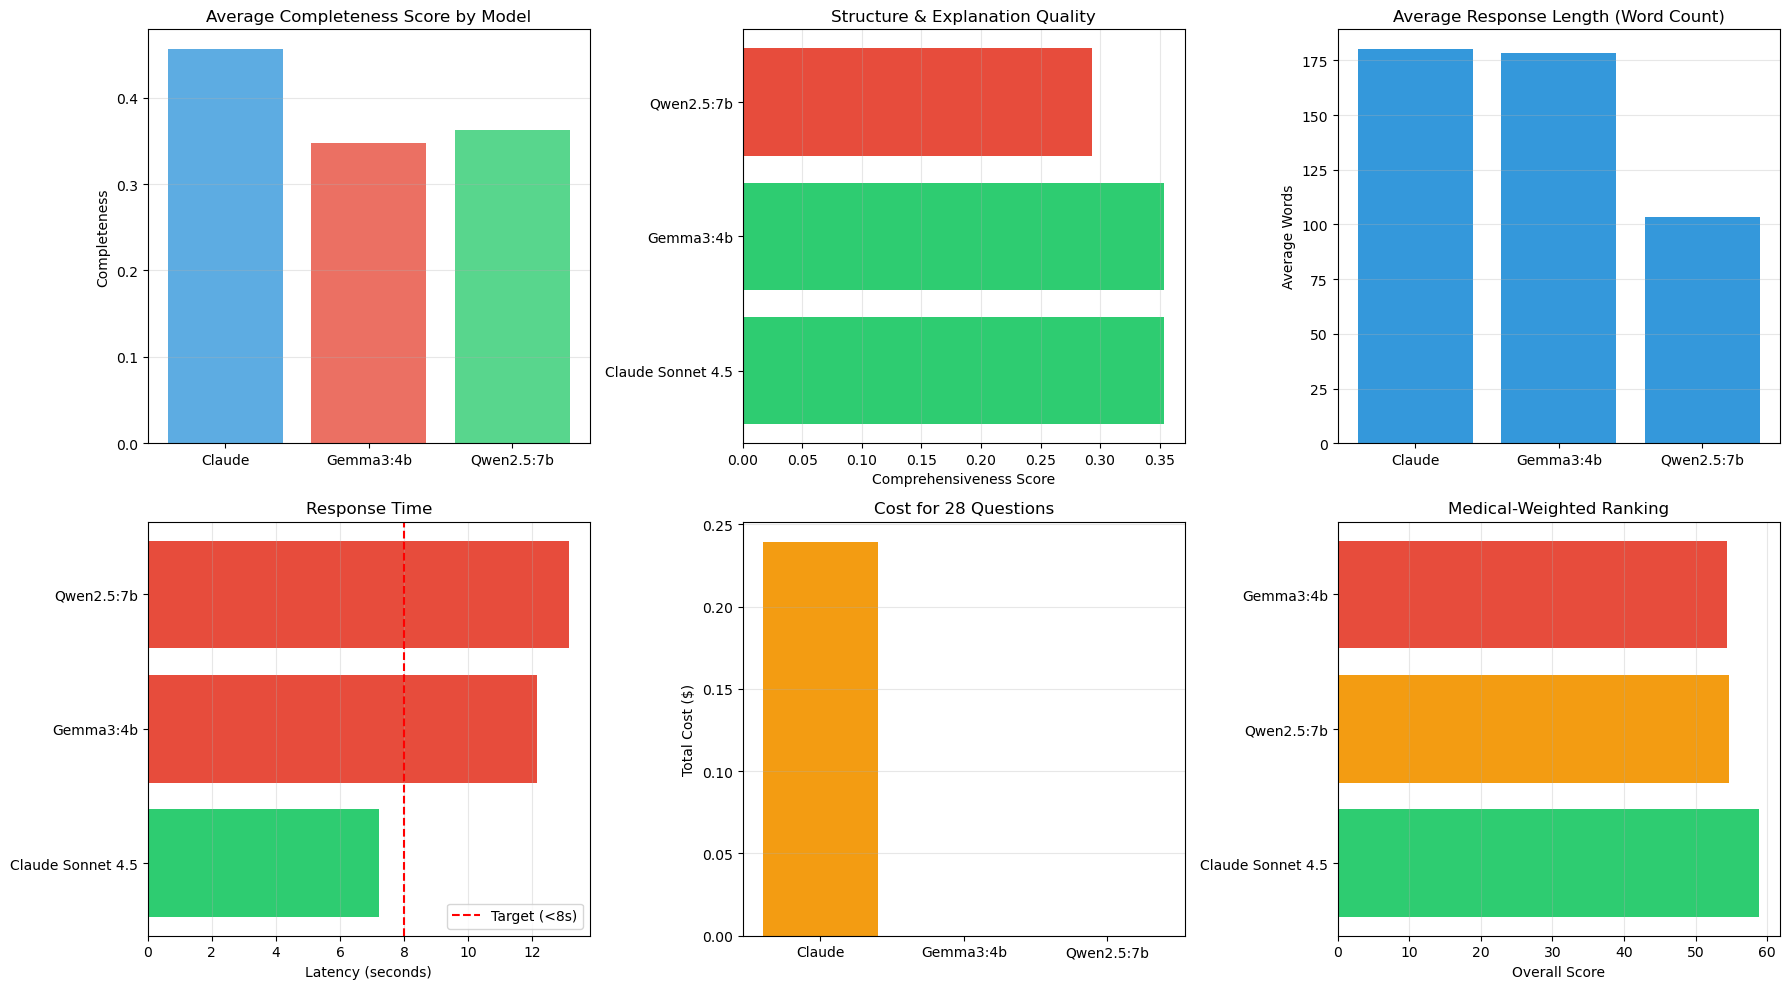

✓ Visualization saved


In [15]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

models_list = list(aggregate_metrics.keys())
width = 0.35

# 1. Completeness by model
ax = axes[0, 0]
completeness_scores = [aggregate_metrics[m]['avg_completeness'] for m in models_list]
bar_colors = ['#3498db', '#e74c3c', '#2ecc71'][:len(models_list)]
x = np.arange(len(models_list))
ax.bar(x, completeness_scores, color=bar_colors, alpha=0.8)
ax.set_ylabel('Completeness')
ax.set_title('Average Completeness Score by Model')
ax.set_xticks(x)
ax.set_xticklabels([m.split()[0] for m in models_list])
ax.grid(axis='y', alpha=0.3)

# 2. Comprehensiveness Bonus
ax = axes[0, 1]
comp_bonus = [aggregate_metrics[m]['avg_comprehensiveness'] for m in models_list]
colors = ['#2ecc71' if c > 0.3 else '#e74c3c' for c in comp_bonus]
ax.barh(models_list, comp_bonus, color=colors)
ax.set_xlabel('Comprehensiveness Score')
ax.set_title('Structure & Explanation Quality')
ax.grid(axis='x', alpha=0.3)

# 3. Answer Length
ax = axes[0, 2]
word_counts = [aggregate_metrics[m]['avg_word_count'] for m in models_list]
ax.bar(models_list, word_counts, color='#3498db')
ax.set_ylabel('Average Words')
ax.set_title('Average Response Length (Word Count)')
ax.set_xticklabels([m.split()[0] for m in models_list])
ax.grid(axis='y', alpha=0.3)

# 4. Latency
ax = axes[1, 0]
latencies = [aggregate_metrics[m]['avg_latency'] for m in models_list]
colors = ['#2ecc71' if l < 8 else '#e74c3c' for l in latencies]
ax.barh(models_list, latencies, color=colors)
ax.axvline(x=8.0, color='red', linestyle='--', label='Target (<8s)')
ax.set_xlabel('Latency (seconds)')
ax.set_title('Response Time')
ax.legend()
ax.grid(axis='x', alpha=0.3)

# 5. Cost
ax = axes[1, 1]
costs = [aggregate_metrics[m]['total_cost'] for m in models_list]
ax.bar(models_list, costs, color='#f39c12')
ax.set_ylabel('Total Cost ($)')
ax.set_title('Cost for 28 Questions')
ax.set_xticklabels([m.split()[0] for m in models_list])
ax.grid(axis='y', alpha=0.3)

# 6. Overall Ranking
ax = axes[1, 2]
scores = ranking_df['Overall Score'].values
names = ranking_df['Model'].values
colors_rank = ['#2ecc71', '#f39c12', '#e74c3c'][:len(names)]
ax.barh(names, scores, color=colors_rank)
ax.set_xlabel('Overall Score')
ax.set_title('Medical-Weighted Ranking')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved")

## 💾 Export Results

In [17]:
%pip install tabulate

output_dir = Path('evaluation_results')
output_dir.mkdir(exist_ok=True)

# Export CSVs
comparison_df.to_csv(output_dir / 'aggregate_metrics.csv')
ranking_df.to_csv(output_dir / 'ranking.csv', index=False)

for model_name, results in all_results.items():
    if results:
        df = pd.DataFrame([asdict(r) for r in results])
        safe_name = model_name.replace(' ', '_').replace(':', '_')
        df.to_csv(output_dir / f'{safe_name}_detailed.csv', index=False)

# Summary markdown
with open(output_dir / 'EVALUATION_SUMMARY.md', 'w') as f:
    f.write("# Medical RAG Evaluation\n\n")
    f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}\n\n")
    
    f.write("## Rankings\n\n")
    f.write(ranking_df.to_markdown(index=False))
    f.write("\n\n## Detailed Metrics\n\n")
    f.write(comparison_df.to_markdown())
    
    f.write("\n\n## Key Findings\n\n")
    top_model = ranking_df.iloc[0]['Model']
    f.write(f"**Winner: {top_model}**\n\n")
    
    for name in models_list:
        m = aggregate_metrics[name]
        f.write(f"\n### {name}\n")
        f.write(f"- Completeness: {m['avg_completeness']:.1%}\n")
        f.write(f"- Comprehensiveness: {m['avg_comprehensiveness']:.1%}\n")
        f.write(f"- Avg Word Count: {m['avg_word_count']:.0f}\n")
        f.write(f"- Latency: {m['avg_latency']:.2f}s\n")
        f.write(f"- Cost: ${m['total_cost']:.3f}\n")

print(f"\n✓ Results exported to '{output_dir}'")

Note: you may need to restart the kernel to use updated packages.

✓ Results exported to 'evaluation_results'


## 🎓 Final Recommendation

In [18]:
print("\n" + "="*80)
print("FINAL RECOMMENDATION FOR MEDICAL COACHING")
print("="*80)

top_model = ranking_df.iloc[0]['Model']
top_score = ranking_df.iloc[0]['Overall Score']

print(f"\n🥇 Winner: {top_model} ({top_score:.1f}/100)\n")

for name in models_list:
    score = overall_scores[name]
    m = aggregate_metrics[name]
    print(f"\n{name}:")
    print(f"  Overall Score: {score:.1f}/100")
    print(f"  Completeness: {m['avg_completeness']:.1%}")
    print(f"  Comprehensiveness: {m['avg_comprehensiveness']:.1%}")
    print(f"  Word Count: {m['avg_word_count']:.0f}")
    print(f"  Latency: {m['avg_latency']:.2f}s | Cost: ${m['total_cost']:.3f}")

print("\n" + "="*80)
print("KEY INSIGHT:")
print("="*80)
print("""For medical coaching applications, the scoring framework prioritises:
- Comprehensive answers that cover exercises, parameters, and clinical context
- Structured format (headers, bullets) for patient readability
- Explanatory content that conveys WHY, not just WHAT
- Explicit safety guidance and professional referrals""")


FINAL RECOMMENDATION FOR MEDICAL COACHING

🥇 Winner: Claude Sonnet 4.5 (58.8/100)


Claude Sonnet 4.5:
  Overall Score: 58.8/100
  Completeness: 45.6%
  Comprehensiveness: 35.4%
  Word Count: 180
  Latency: 7.23s | Cost: $0.240

Gemma3:4b:
  Overall Score: 54.4/100
  Completeness: 34.7%
  Comprehensiveness: 35.4%
  Word Count: 178
  Latency: 12.15s | Cost: $0.000

Qwen2.5:7b:
  Overall Score: 54.7/100
  Completeness: 36.3%
  Comprehensiveness: 29.3%
  Word Count: 103
  Latency: 13.14s | Cost: $0.000

KEY INSIGHT:
For medical coaching applications, the scoring framework prioritises:
- Comprehensive answers that cover exercises, parameters, and clinical context
- Structured format (headers, bullets) for patient readability
- Explanatory content that conveys WHY, not just WHAT
- Explicit safety guidance and professional referrals


## 📊 Claude: Prompt Length vs Latency Analysis

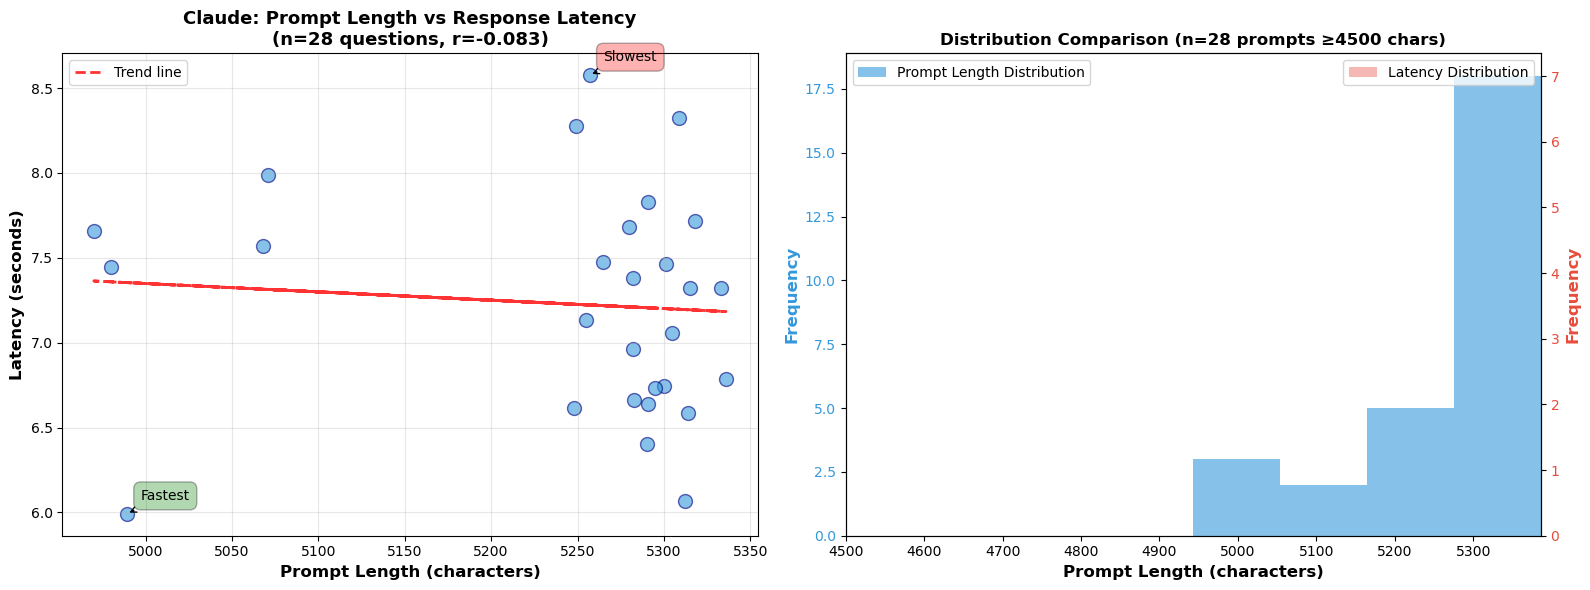


CLAUDE: PROMPT LENGTH vs LATENCY ANALYSIS

Prompt Length Statistics (characters):
  Mean: 5,242
  Median: 5,286
  Min: 4,970
  Max: 5,336
  Std Dev: 110

Latency Statistics (seconds):
  Mean: 7.230
  Median: 7.323
  Min: 5.992
  Max: 8.577
  Std Dev: 0.649

Correlation:
  Pearson r: -0.083
  Interpretation: Weak negative correlation

5 Slowest Responses:
  1. How long does it take for shoulder impin | Prompt: 5,257 chars | Latency: 8.577s
  2. My knee makes grinding and cracking soun | Prompt: 5,309 chars | Latency: 8.322s
  3. When should I stop an exercise during my | Prompt: 5,249 chars | Latency: 8.280s
  4. What is the 'traffic light' system my ph | Prompt: 5,071 chars | Latency: 7.989s
  5. I have shoulder impingement — are there  | Prompt: 5,291 chars | Latency: 7.832s

✓ Analysis complete. Data available in claude_analysis_df


In [19]:
# Extract Claude results
claude_results = all_results.get('Claude Sonnet 4.5', [])

if claude_results:
    # Calculate prompt lengths and latencies
    prompt_lengths = []
    latencies = []
    questions_list = []
    
    for result in claude_results:
        # Calculate total prompt length
        question_len = len(result.question)
        
        # Context length from retrieved docs
        context_len = sum(len(d['content']) for d in result.retrieved_docs)
        
        # System prompt overhead (instruction)
        system_overhead = len("""You are a physical therapy assistant. Answer based on these documents.

Context:

Question: 

Provide a clear, accurate answer. If documents lack info, say so and suggest consulting a professional.""")
        
        total_prompt = question_len + context_len + system_overhead
        
        prompt_lengths.append(total_prompt)
        latencies.append(result.latency_seconds)
        questions_list.append(result.question[:40])
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Scatter plot: Prompt Length vs Latency
    ax = axes[0]
    ax.scatter(prompt_lengths, latencies, s=100, alpha=0.6, edgecolors='navy', color='#3498db')
    
    # Add trend line
    z = np.polyfit(prompt_lengths, latencies, 1)
    p = np.poly1d(z)
    ax.plot(prompt_lengths, p(prompt_lengths), "r--", alpha=0.8, linewidth=2, label='Trend line')
    
    # Correlation
    correlation = np.corrcoef(prompt_lengths, latencies)[0, 1]
    
    ax.set_xlabel('Prompt Length (characters)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Latency (seconds)', fontsize=12, fontweight='bold')
    ax.set_title(f'Claude: Prompt Length vs Response Latency\n(n={len(claude_results)} questions, r={correlation:.3f})', 
                fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Add annotations for interesting points
    min_latency_idx = np.argmin(latencies)
    max_latency_idx = np.argmax(latencies)
    
    ax.annotate('Fastest', xy=(prompt_lengths[min_latency_idx], latencies[min_latency_idx]),
               xytext=(10, 10), textcoords='offset points', ha='left',
               bbox=dict(boxstyle='round,pad=0.5', fc='green', alpha=0.3),
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    ax.annotate('Slowest', xy=(prompt_lengths[max_latency_idx], latencies[max_latency_idx]),
               xytext=(10, 10), textcoords='offset points', ha='left',
               bbox=dict(boxstyle='round,pad=0.5', fc='red', alpha=0.3),
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    # Distribution plots - FILTERED to 4500+ characters
    ax = axes[1]
    ax2 = ax.twinx()
    
    # Filter to prompts >= 4500 characters
    filtered_indices = [i for i, p in enumerate(prompt_lengths) if p >= 4500]
    filtered_prompts = [prompt_lengths[i] for i in filtered_indices]
    filtered_latencies = [latencies[i] for i in filtered_indices]
    
    # Histogram of prompt lengths (4500+) with manual range
    counts, bins, patches = ax.hist(filtered_prompts, bins=8, range=(4500, max(filtered_prompts)+50), 
                                    alpha=0.6, color='#3498db', label='Prompt Length Distribution')
    ax.set_xlabel('Prompt Length (characters)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=12, fontweight='bold', color='#3498db')
    ax.tick_params(axis='y', labelcolor='#3498db')
    ax.set_xlim(4500, max(filtered_prompts)+50)  # Focus on 4500+ range
    
    # Overlay latency distribution (for filtered data)
    ax2.hist(filtered_latencies, bins=8, alpha=0.4, color='#e74c3c', label='Latency Distribution')
    ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold', color='#e74c3c')
    ax2.tick_params(axis='y', labelcolor='#e74c3c')
    ax2.set_title(f'Distribution Comparison (n={len(filtered_prompts)} prompts ≥4500 chars)', fontsize=12, fontweight='bold')
    
    # Legends
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.tight_layout()
    plt.savefig('claude_prompt_length_vs_latency.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\n" + "="*80)
    print("CLAUDE: PROMPT LENGTH vs LATENCY ANALYSIS")
    print("="*80)
    print(f"\nPrompt Length Statistics (characters):")
    print(f"  Mean: {np.mean(prompt_lengths):,.0f}")
    print(f"  Median: {np.median(prompt_lengths):,.0f}")
    print(f"  Min: {np.min(prompt_lengths):,.0f}")
    print(f"  Max: {np.max(prompt_lengths):,.0f}")
    print(f"  Std Dev: {np.std(prompt_lengths):,.0f}")
    
    print(f"\nLatency Statistics (seconds):")
    print(f"  Mean: {np.mean(latencies):.3f}")
    print(f"  Median: {np.median(latencies):.3f}")
    print(f"  Min: {np.min(latencies):.3f}")
    print(f"  Max: {np.max(latencies):.3f}")
    print(f"  Std Dev: {np.std(latencies):.3f}")
    
    print(f"\nCorrelation:")
    print(f"  Pearson r: {correlation:.3f}")
    print(f"  Interpretation: {'Weak' if abs(correlation) < 0.3 else 'Moderate' if abs(correlation) < 0.7 else 'Strong'} {'positive' if correlation > 0 else 'negative'} correlation")
    
    # Show outliers
    print(f"\n5 Slowest Responses:")
    sorted_idx = sorted(range(len(latencies)), key=lambda i: latencies[i], reverse=True)[:5]
    for rank, idx in enumerate(sorted_idx, 1):
        print(f"  {rank}. {questions_list[idx]} | Prompt: {prompt_lengths[idx]:,} chars | Latency: {latencies[idx]:.3f}s")
    
    # Create data frame for further analysis
    claude_analysis_df = pd.DataFrame({
        'Question': questions_list,
        'Prompt_Length': prompt_lengths,
        'Latency_Seconds': latencies
    })
    
    print(f"\n✓ Analysis complete. Data available in claude_analysis_df")
else:
    print("✗ Claude results not found")

## 📊 Claude: Response Size (Words/Tokens) vs Latency Analysis


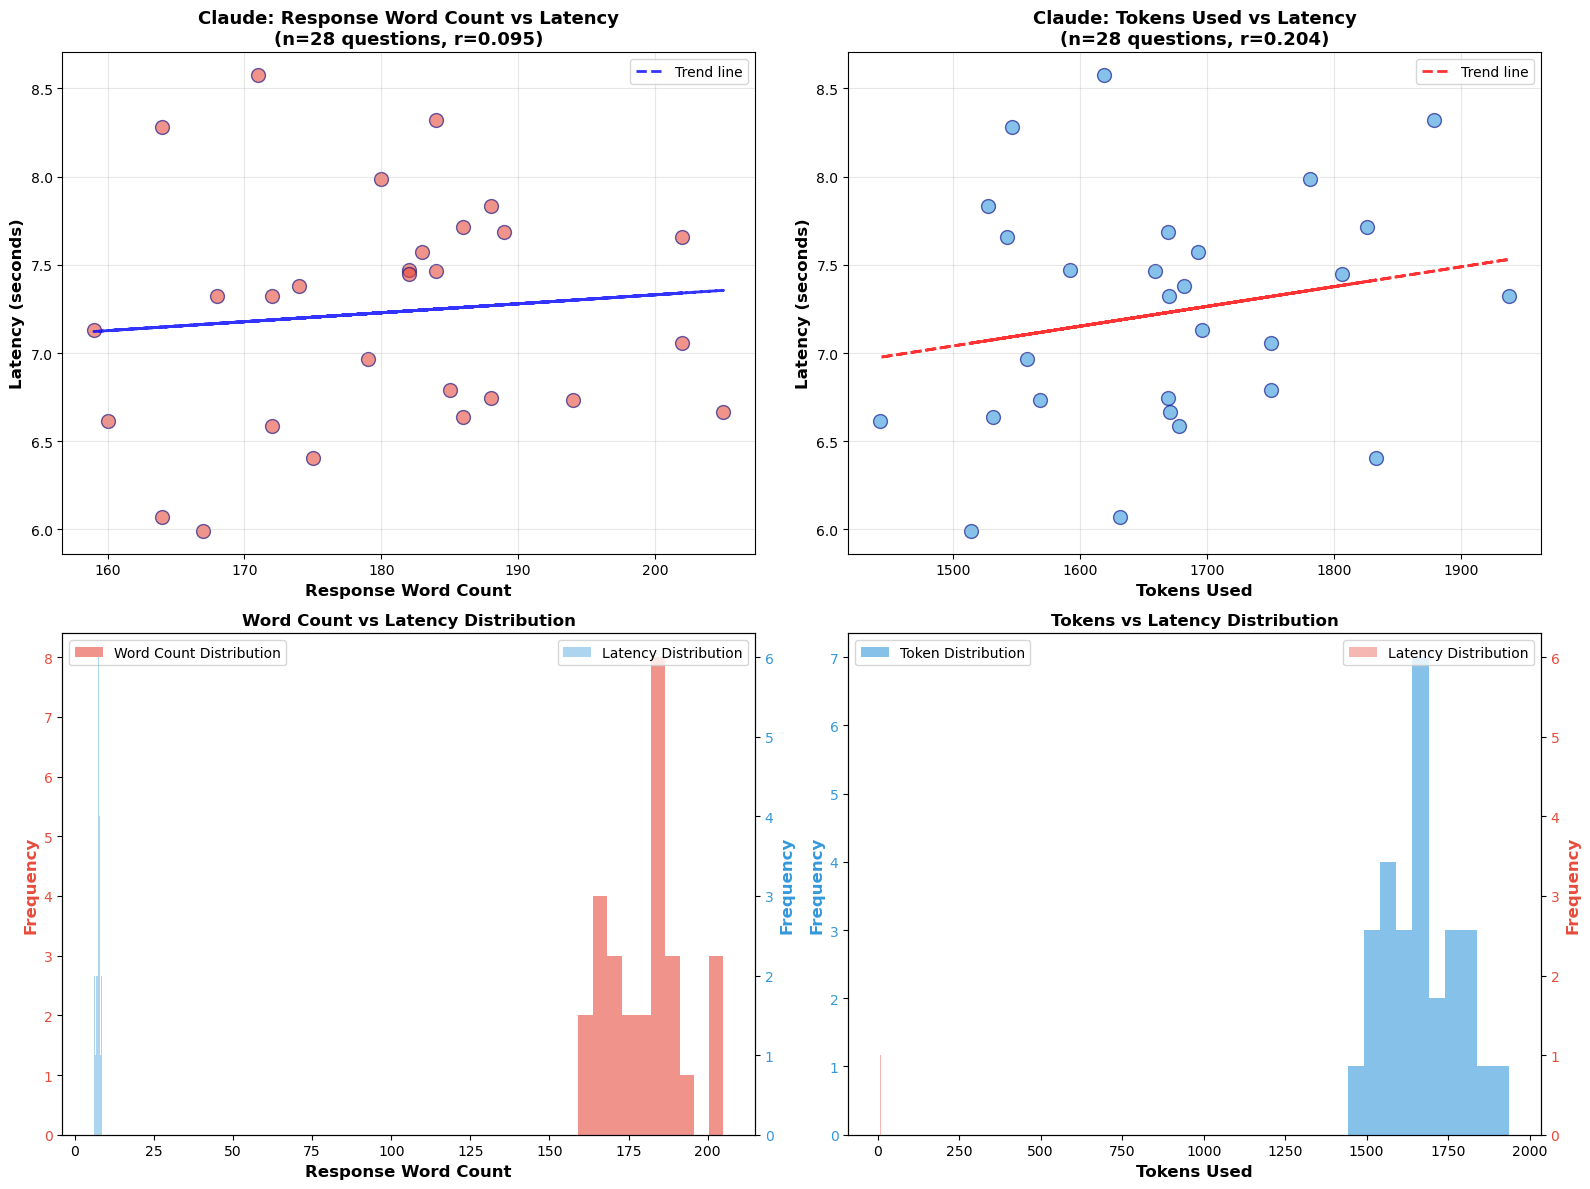


CLAUDE: RESPONSE SIZE vs LATENCY ANALYSIS

Word Count Statistics:
  Mean: 180
  Median: 182
  Min: 159
  Max: 205
  Std Dev: 12

Tokens Used Statistics:
  Mean: 1669
  Median: 1670
  Min: 1442
  Max: 1938
  Std Dev: 118

Correlations with Latency:
  Word Count: r = 0.095
    Interpretation: Weak positive correlation
  Tokens: r = 0.204
    Interpretation: Weak positive correlation

Long Responses (>182 words) vs Short Responses (≤182 words):
  Long avg latency: 7.298s
  Short avg latency: 7.171s
  Difference: 0.127s

5 Longest Responses:
  1. What does a proper single leg squat look | Words: 205 | Latency: 6.663s
  2. What signs should I watch out for during | Words: 202 | Latency: 7.657s
  3. I've got lateral hip pain / hip bursitis | Words: 202 | Latency: 7.057s
  4. I've had back pain for a few weeks now.  | Words: 194 | Latency: 6.731s
  5. I have a rotator cuff tear — is it safe  | Words: 189 | Latency: 7.684s

5 Fastest Responses:
  1. I've been diagnosed with frozen shoulder | 

In [20]:

claude_results = all_results.get('Claude Sonnet 4.5', [])

if claude_results:
    # Extract word counts, tokens, and latencies
    word_counts = []
    tokens_used = []
    latencies = []
    questions_list = []
    
    for result in claude_results:
        word_counts.append(result.answer_word_count)
        tokens_used.append(result.tokens_used)
        latencies.append(result.latency_seconds)
        questions_list.append(result.question[:40])
    
    # Create figure with word count analysis
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Word Count vs Latency - Scatter with trend
    ax = axes[0, 0]
    ax.scatter(word_counts, latencies, s=100, alpha=0.6, edgecolors='navy', color='#e74c3c')
    
    z = np.polyfit(word_counts, latencies, 1)
    p = np.poly1d(z)
    ax.plot(word_counts, p(word_counts), "b--", alpha=0.8, linewidth=2, label='Trend line')
    
    correlation_words = np.corrcoef(word_counts, latencies)[0, 1]
    
    ax.set_xlabel('Response Word Count', fontsize=12, fontweight='bold')
    ax.set_ylabel('Latency (seconds)', fontsize=12, fontweight='bold')
    ax.set_title(f'Claude: Response Word Count vs Latency\n(n={len(claude_results)} questions, r={correlation_words:.3f})', 
                fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # 2. Tokens vs Latency - Scatter with trend
    ax = axes[0, 1]
    ax.scatter(tokens_used, latencies, s=100, alpha=0.6, edgecolors='navy', color='#3498db')
    
    z = np.polyfit(tokens_used, latencies, 1)
    p = np.poly1d(z)
    ax.plot(tokens_used, p(tokens_used), "r--", alpha=0.8, linewidth=2, label='Trend line')
    
    correlation_tokens = np.corrcoef(tokens_used, latencies)[0, 1]
    
    ax.set_xlabel('Tokens Used', fontsize=12, fontweight='bold')
    ax.set_ylabel('Latency (seconds)', fontsize=12, fontweight='bold')
    ax.set_title(f'Claude: Tokens Used vs Latency\n(n={len(claude_results)} questions, r={correlation_tokens:.3f})', 
                fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # 3. Distribution of word counts with latency overlay
    ax = axes[1, 0]
    ax2 = ax.twinx()
    
    counts, bins, patches = ax.hist(word_counts, bins=10, alpha=0.6, color='#e74c3c', label='Word Count Distribution')
    ax.set_xlabel('Response Word Count', fontsize=12, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=12, fontweight='bold', color='#e74c3c')
    ax.tick_params(axis='y', labelcolor='#e74c3c')
    
    ax2.hist(latencies, bins=10, alpha=0.4, color='#3498db', label='Latency Distribution')
    ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold', color='#3498db')
    ax2.tick_params(axis='y', labelcolor='#3498db')
    ax2.set_title('Word Count vs Latency Distribution', fontsize=12, fontweight='bold')
    
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    # 4. Distribution of tokens with latency overlay
    ax = axes[1, 1]
    ax2 = ax.twinx()
    
    counts, bins, patches = ax.hist(tokens_used, bins=10, alpha=0.6, color='#3498db', label='Token Distribution')
    ax.set_xlabel('Tokens Used', fontsize=12, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=12, fontweight='bold', color='#3498db')
    ax.tick_params(axis='y', labelcolor='#3498db')
    
    ax2.hist(latencies, bins=10, alpha=0.4, color='#e74c3c', label='Latency Distribution')
    ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold', color='#e74c3c')
    ax2.tick_params(axis='y', labelcolor='#e74c3c')
    ax2.set_title('Tokens vs Latency Distribution', fontsize=12, fontweight='bold')
    
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.tight_layout()
    plt.savefig('claude_response_size_vs_latency.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\n" + "="*80)
    print("CLAUDE: RESPONSE SIZE vs LATENCY ANALYSIS")
    print("="*80)
    
    print(f"\nWord Count Statistics:")
    print(f"  Mean: {np.mean(word_counts):.0f}")
    print(f"  Median: {np.median(word_counts):.0f}")
    print(f"  Min: {np.min(word_counts):.0f}")
    print(f"  Max: {np.max(word_counts):.0f}")
    print(f"  Std Dev: {np.std(word_counts):.0f}")
    
    print(f"\nTokens Used Statistics:")
    print(f"  Mean: {np.mean(tokens_used):.0f}")
    print(f"  Median: {np.median(tokens_used):.0f}")
    print(f"  Min: {np.min(tokens_used):.0f}")
    print(f"  Max: {np.max(tokens_used):.0f}")
    print(f"  Std Dev: {np.std(tokens_used):.0f}")
    
    print(f"\nCorrelations with Latency:")
    print(f"  Word Count: r = {correlation_words:.3f}")
    print(f"    Interpretation: {'Weak' if abs(correlation_words) < 0.3 else 'Moderate' if abs(correlation_words) < 0.7 else 'Strong'} {'positive' if correlation_words > 0 else 'negative'} correlation")
    print(f"  Tokens: r = {correlation_tokens:.3f}")
    print(f"    Interpretation: {'Weak' if abs(correlation_tokens) < 0.3 else 'Moderate' if abs(correlation_tokens) < 0.7 else 'Strong'} {'positive' if correlation_tokens > 0 else 'negative'} correlation")
    
    # Identify long vs short responses
    median_words = np.median(word_counts)
    long_responses = [i for i, w in enumerate(word_counts) if w > median_words]
    short_responses = [i for i, w in enumerate(word_counts) if w <= median_words]
    
    print(f"\nLong Responses (>{median_words:.0f} words) vs Short Responses (≤{median_words:.0f} words):")
    print(f"  Long avg latency: {np.mean([latencies[i] for i in long_responses]):.3f}s")
    print(f"  Short avg latency: {np.mean([latencies[i] for i in short_responses]):.3f}s")
    print(f"  Difference: {abs(np.mean([latencies[i] for i in long_responses]) - np.mean([latencies[i] for i in short_responses])):.3f}s")
    
    # Show examples
    print(f"\n5 Longest Responses:")
    sorted_word_idx = sorted(range(len(word_counts)), key=lambda i: word_counts[i], reverse=True)[:5]
    for rank, idx in enumerate(sorted_word_idx, 1):
        print(f"  {rank}. {questions_list[idx]} | Words: {word_counts[idx]} | Latency: {latencies[idx]:.3f}s")
    
    print(f"\n5 Fastest Responses:")
    sorted_latency_idx = sorted(range(len(latencies)), key=lambda i: latencies[i])[:5]
    for rank, idx in enumerate(sorted_latency_idx, 1):
        print(f"  {rank}. {questions_list[idx]} | Words: {word_counts[idx]} | Latency: {latencies[idx]:.3f}s")
    
    # Create data frame for further analysis
    response_size_analysis_df = pd.DataFrame({
        'Question': questions_list,
        'Word_Count': word_counts,
        'Tokens_Used': tokens_used,
        'Latency_Seconds': latencies
    })
    
    print(f"\n✓ Analysis complete. Data available in response_size_analysis_df")
else:
    print("✗ Claude results not found")


## 📊 Cross-Model: Response Size vs Latency Comparison


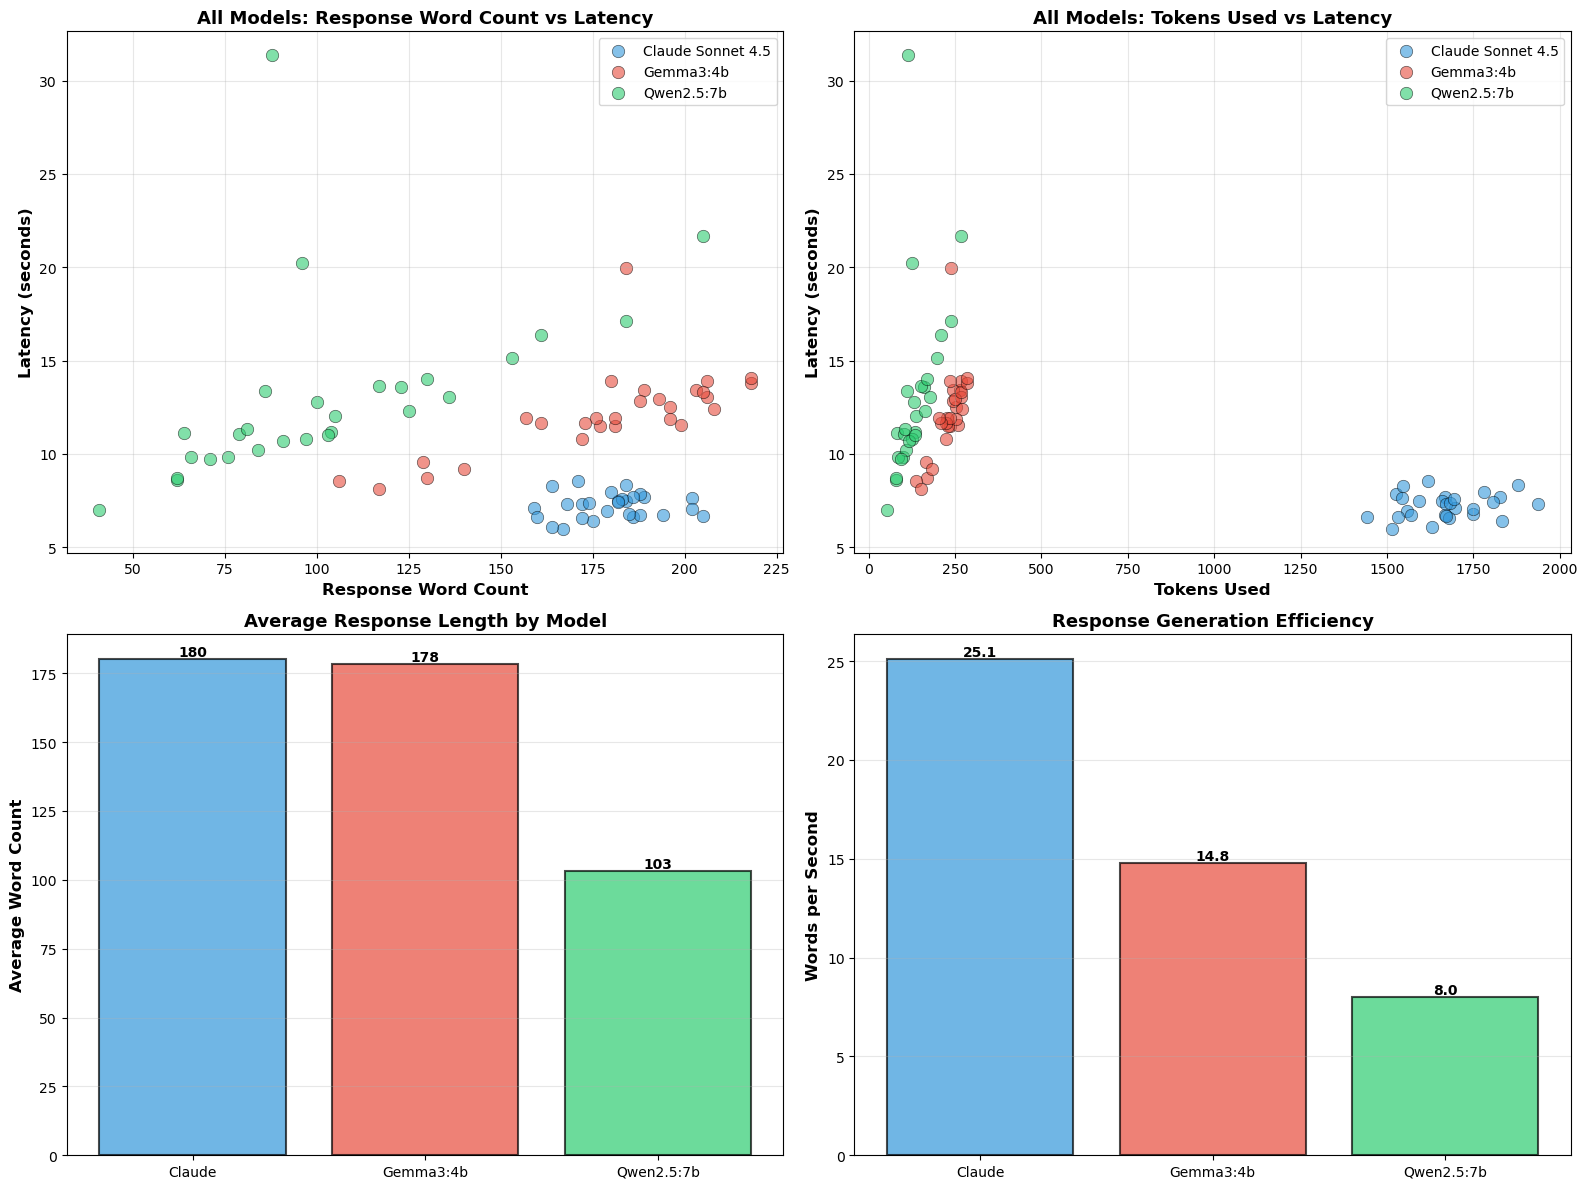


CROSS-MODEL: RESPONSE SIZE vs LATENCY COMPARISON

Claude Sonnet 4.5:
  Response Length:
    Avg words: 180 (±12)
    Avg tokens: 1669 (±118)
  Latency:
    Avg: 7.230s (±0.649s)
  Correlations with Latency:
    Word count: r = 0.095
    Tokens: r = 0.204
  Efficiency (words/sec): 25.1 (±2.6)

Gemma3:4b:
  Response Length:
    Avg words: 178 (±30)
    Avg tokens: 231 (±38)
  Latency:
    Avg: 12.149s (±2.236s)
  Correlations with Latency:
    Word count: r = 0.698
    Tokens: r = 0.699
  Efficiency (words/sec): 14.8 (±1.5)

Qwen2.5:7b:
  Response Length:
    Avg words: 103 (±38)
    Avg tokens: 134 (±49)
  Latency:
    Avg: 13.141s (±4.777s)
  Correlations with Latency:
    Word count: r = 0.496
    Tokens: r = 0.496
  Efficiency (words/sec): 8.0 (±1.8)

SUMMARY TABLE
            Model  Avg_Words  Avg_Tokens  Avg_Latency  Words_Latency_Correlation  Tokens_Latency_Correlation  Efficiency_Words_Per_Sec
Claude Sonnet 4.5    180.179    1668.571        7.230                      0.095      

In [21]:

# Cross-model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models_list = list(all_results.keys())
colors = ['#3498db', '#e74c3c', '#2ecc71']

# 1. Word Count vs Latency - All models
ax = axes[0, 0]
for model_name, color in zip(models_list, colors):
    results = all_results[model_name]
    if results:
        word_counts = [r.answer_word_count for r in results]
        latencies = [r.latency_seconds for r in results]
        ax.scatter(word_counts, latencies, s=80, alpha=0.6, color=color, label=model_name, edgecolors='black', linewidth=0.5)

ax.set_xlabel('Response Word Count', fontsize=12, fontweight='bold')
ax.set_ylabel('Latency (seconds)', fontsize=12, fontweight='bold')
ax.set_title('All Models: Response Word Count vs Latency', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# 2. Tokens vs Latency - All models
ax = axes[0, 1]
for model_name, color in zip(models_list, colors):
    results = all_results[model_name]
    if results:
        tokens = [r.tokens_used for r in results]
        latencies = [r.latency_seconds for r in results]
        ax.scatter(tokens, latencies, s=80, alpha=0.6, color=color, label=model_name, edgecolors='black', linewidth=0.5)

ax.set_xlabel('Tokens Used', fontsize=12, fontweight='bold')
ax.set_ylabel('Latency (seconds)', fontsize=12, fontweight='bold')
ax.set_title('All Models: Tokens Used vs Latency', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# 3. Average Word Count Comparison
ax = axes[1, 0]
avg_word_counts = []
for model_name in models_list:
    results = all_results[model_name]
    if results:
        avg = np.mean([r.answer_word_count for r in results])
        avg_word_counts.append(avg)
    else:
        avg_word_counts.append(0)

bars = ax.bar(range(len(models_list)), avg_word_counts, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Average Word Count', fontsize=12, fontweight='bold')
ax.set_title('Average Response Length by Model', fontsize=13, fontweight='bold')
ax.set_xticks(range(len(models_list)))
ax.set_xticklabels([m.split()[0] for m in models_list])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold')

# 4. Efficiency Score: Words per Second
ax = axes[1, 1]
efficiency_scores = []
model_labels = []

for model_name in models_list:
    results = all_results[model_name]
    if results:
        word_counts = [r.answer_word_count for r in results]
        latencies = [r.latency_seconds for r in results]
        efficiency = [w/l if l > 0 else 0 for w, l in zip(word_counts, latencies)]
        avg_efficiency = np.mean(efficiency)
        efficiency_scores.append(avg_efficiency)
        model_labels.append(model_name.split()[0])

bars = ax.bar(range(len(efficiency_scores)), efficiency_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Words per Second', fontsize=12, fontweight='bold')
ax.set_title('Response Generation Efficiency', fontsize=13, fontweight='bold')
ax.set_xticks(range(len(model_labels)))
ax.set_xticklabels(model_labels)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('cross_model_response_size_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print comprehensive comparison
print("\n" + "="*80)
print("CROSS-MODEL: RESPONSE SIZE vs LATENCY COMPARISON")
print("="*80)

comparison_data = []

for model_name in models_list:
    results = all_results[model_name]
    if not results:
        continue
    
    word_counts = [r.answer_word_count for r in results]
    tokens = [r.tokens_used for r in results]
    latencies = [r.latency_seconds for r in results]
    
    # Correlations
    corr_words = np.corrcoef(word_counts, latencies)[0, 1]
    corr_tokens = np.corrcoef(tokens, latencies)[0, 1] if tokens else 0
    
    # Efficiency
    efficiency = [w/l if l > 0 else 0 for w, l in zip(word_counts, latencies)]
    
    print(f"\n{model_name}:")
    print(f"  Response Length:")
    print(f"    Avg words: {np.mean(word_counts):.0f} (±{np.std(word_counts):.0f})")
    print(f"    Avg tokens: {np.mean(tokens):.0f} (±{np.std(tokens):.0f})")
    print(f"  Latency:")
    print(f"    Avg: {np.mean(latencies):.3f}s (±{np.std(latencies):.3f}s)")
    print(f"  Correlations with Latency:")
    print(f"    Word count: r = {corr_words:.3f}")
    print(f"    Tokens: r = {corr_tokens:.3f}")
    print(f"  Efficiency (words/sec): {np.mean(efficiency):.1f} (±{np.std(efficiency):.1f})")
    
    comparison_data.append({
        'Model': model_name,
        'Avg_Words': np.mean(word_counts),
        'Avg_Tokens': np.mean(tokens),
        'Avg_Latency': np.mean(latencies),
        'Words_Latency_Correlation': corr_words,
        'Tokens_Latency_Correlation': corr_tokens,
        'Efficiency_Words_Per_Sec': np.mean(efficiency)
    })

# Create DataFrame
cross_model_comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)
print(cross_model_comparison_df.round(3).to_string(index=False))

print(f"\n✓ Cross-model analysis complete. Data available in cross_model_comparison_df")
